# Decision trees

In this unit, we will illustrate **decision trees** using the Titanic data. Our goal is to build a model that can predict whether a passenger from the Titanic survived or not based on several features including its age, sex and passenger class (1st, 2nd or 3rd).

In the first part of this unit, we will see the basic idea behind decision trees. We will then build one for the Titanic data set using Scikit-learn. You can download the data set from the resource section.

The idea behind decision trees is to learn a set of **if-then-else rules** that lead to a final decision. In classification tasks, this decision is a label. This may sound abstract, so let's take an example. Here is a simple decision tree with two if-then-else statements that encode the principle "women and children first".

In [ ]:
from IPython.display import Image
Image(url='https://d7whxh71cqykp.cloudfront.net/uploads/image/data/2812/decision_trees.svg', width = 400)

In this image, the squares in gray are binary statements that can be either true or false. Each outcome corresponds to a branch of the three and leads to another statement (called a **node**) or to a final label (called a **leaf**). In the Titanic example, the age and sex of the passengers are features, and we want to build a tree that leads to one of the two labels in our classification task: survived or died. To classify a new sample, we start at the top of the tree (called its **root**) and evaluate each statement on the path until reaching a leaf.

### Impurity measures

The main challenge here is to create meaningful rules to separate our data set into "pure" subsets that have samples with similar target values. In our binary classification case, we want the leaves to have most of the samples labeled with either "died" or "survived". We can quantify how "pure" each leaf is by counting the proportion of entries labeled with the positive class (an estimation of $p(y=1)$ at the leaf). If this probability is close to 0 or 1, then it means that the leaf is "pure" in the sense that most of its samples are from the same class.

In practice, we want to build rules that minimize an **impurity measure** at each leaf. For instance, we can measure the **misclassification impurity** which is simply the error rate at a leaf when predicting the most frequent class.

> $Imisclassification(p)=1−max(p,1−p)$

For instance, if 80% of the samples at a leaf are labeled with "survived", then 
p is 0.8, and the misclassification impurity is 20% since we expect to have an error rate of 20% when predicting the label "survived" at that leaf. Note that there are other possible impurity measures. For instance, we can use **cross-entropy (CE)** which is a way to quantify uncertainty (or disorder).

> $Icross-entropy(p)=−p.log2(p)−(1−p).log2(1−p)$

However, in practice, we prefer to use **Gini impurity** which is very similar to cross-entropy but faster to compute.

> $Igini(p)=2p(1−p)$

In [ ]:
Image(url='https://d7whxh71cqykp.cloudfront.net/uploads/image/data/5638/impurity-functions.svg')


Note that the misclassification and Gini measures range between 0 and 0.5 while cross-entropy between 0 and 1. In this image, we rescaled cross-entropy such that all impurity functions have a maximum value of 0.5.

As we can see, all functions have an impurity of zero when the set contains only examples from one class (
p
=
0
 or 
p
=
1
), and the impurity is maximal when half of the samples come from each class (
p
=
0.5
).

### Building the decision tree

When building a decision tree, we start at the top of the tree and iteratively try to find a split that minimizes the impurity at the leaves.

In [ ]:
Image(url='https://d7whxh71cqykp.cloudfront.net/uploads/image/data/2810/split_impurity.svg')


In this image, the box in gray corresponds to a condition on a feature (e.g., age lower than 12, or passenger class is 1st). We denote the impurity measure at each leaf with 
$I(pL)$ and $I(pR)$ where $pL$ and $pR$ are the probabilities of the positive class in the left and right leaves. Our goal is to find a split that minimizes the **total impurity**.

> $Isplit=nLI(pL)+nRI(pR)$

In this equation, we compute the split impurity $Isplit$ by summing the impurity values at each leaf weighted by their number of samples $nL$ and $nR$. In a typical scenario, we test different conditions for each feature in our data set and **select the one with the minimum split impurity**. We can then continue to split the leaves until we get "pure" leaves with samples from a single class. In practice, the rules become more specific after each split, and the tree starts overfitting. For this reason, we usually set a limit on its depth.

We will now go through a concrete example and build a decision tree for the Titanic data set using Scikit-learn.

### Data preprocessing

In [4]:
import pandas as pd

# Load data
data_df = pd.read_csv('titanic.csv')

# First five rows
data_df.head()

,name,pclass,age,sex,survived
0,"Hirvonen, Miss Hildur E",3rd,2,female,0
1,"Van Impe, Miss Catharine",3rd,10,female,0
2,"Sjostedt, Mr Ernst Adolf",2nd,59,male,0
3,"Fortune, Mr Mark",1st,64,male,0
4,"Ware, Mr William J",2nd,23,male,0


The data contains five variables. The features are the name of the passenger, its class, age and sex, and the target variable indicates if the passenger survived.

Scikit-learn cannot work directly on this DataFrame to build the decision tree, but we can convert it into the usual X/y Numpy arrays by encoding categories with numerical values. We will use a simple 0/1 encoding for the binary sex feature and one-hot encoding for the pclass variable which has three possible values.

In [5]:
# One-hot encoding
encoded_df = pd.get_dummies(data_df, columns=['pclass'])

# Encode binary variables with 0s and 1s
encoded_df['sex'] = encoded_df.sex.replace({
    'male': 0,
    'female': 1
})

# First five rows
encoded_df.head()

,name,age,sex,survived,pclass_1st,pclass_2nd,pclass_3rd
0,"Hirvonen, Miss Hildur E",2,1,0,0,0,1
1,"Van Impe, Miss Catharine",10,1,0,0,0,1
2,"Sjostedt, Mr Ernst Adolf",59,0,0,0,1,0
3,"Fortune, Mr Mark",64,0,0,1,0,0
4,"Ware, Mr William J",23,0,0,0,1,0


In this code, we create a dummy variable for each passenger class using the get_dummies() function from Pandas, and we replace the male and female values with numerical 0/1 labels. The encoded_df DataFrame now only contains numerical values (except the name variable, but we will drop it before building the tree).

We can now create the X/y arrays.

In [6]:
import numpy as np

# Select features
features = encoded_df.drop(['name', 'survived'], axis=1)

# Create X/y arrays
X = features.values
y = encoded_df.survived.values

At the moment, Scikit-learn doesn't support categorical variables. Hence, we need to encode them using one-hot encoding. However, note that there is an ongoing effort by the community to solve this. You can take a look at this link if you want to learn more about it.

https://github.com/scikit-learn/scikit-learn/pull/4899

### Scikit-learn DecisionTreeClassifier

Scikit-learn provides a DecisionTreeClassifier estimator to build decision trees. Let's start with a simple decision tree with a depth of one that minimizes the Gini impurity measure at each split.

In [7]:
from sklearn.tree import DecisionTreeClassifier

# Create decision tree
dt = DecisionTreeClassifier(
    criterion='gini', max_depth=1, random_state=0)

The estimator shuffles the features at each split. Hence, the results may vary when there are ties (two splits with the same impurity score). In the code from above, we set the random_state parameter to zero to fix the results.

We can now create and evaluate the decision tree using the fit() and the score() functions.

In [8]:
# Fit decision tree
dt.fit(X, y)

# Get score
dt.score(X, y)

0.7791005291005291

In [9]:
# Proportion of features in each class
pd.value_counts(y, normalize=True)

0    0.585979
1    0.414021
dtype: float64

We get an accuracy around 78% which is already much better than the "most-frequent" baseline.

Note that we removed part of the entries labeled with "died" in the titanic.csv file to have a more balanced the data set (the survival rate is around 30% according to Wikipedia and not 40% as above). **Decision trees try to minimize the impurity at each split**. Hence, if there are more samples from one class than the others, **it will focus on building rules that correctly classify data points from this class**. In our case, we want to build a decision tree that can classify well samples from both categories. **Hence, it's important that they have approximately the same number of samples.**

**This problem is not specific to decision tree**s. For instance, a k-NN classifier will also favor points from the dominant classes when doing the majority vote. This is called the **class imbalance problem.**

> Note: Another way to solve the issue is to modify the objective function of our classifiers and put more weight on classes that are underrepresented in the training set. We won't go into the details in this course, but note that Scikit-learn implements this strategy with the class_weight parameter that you can set to balanced when it's important that your classifier performs well with all classes independently of how many samples you have from each in your training set.

### Visualize decision trees

One of the main advantages of decision trees is that they are easy to interpret.

Each node corresponds to a simple rule.
The most important ones are at the top of the decision tree.
We can visualize them using a library called **Graphvi**. Scikit-learn implements an export_graphviz() function to export decision tree estimators into the Graphviz .dot format.

In [10]:
from sklearn.tree import export_graphviz

# Export decision tree
dot_data = export_graphviz(
    dt, out_file=None,
    feature_names=features.columns, class_names=['died', 'survived'],
    filled=True, rounded=True, proportion=True   
)

In this code, we create a dot_data variable from our decision tree dt. This variable contains all the information to plot our decision tree. Note that the function provides many arguments to customize its appearance and to specify what information it contains. In our case, there are three important arguments.

* feature_names - the names of the features in X
* class_names - the names of the classes in y
* proportion=True - to include the proportion of samples in each node

Note that we set the feature names using the features variable from above (encoded_df without its name and survived columns). We won't go into the details of each argument, but you can take a look at this page if you want to learn more about them.

To visualize the decision tree, we need to load it into a Source object from the Graphviz library.

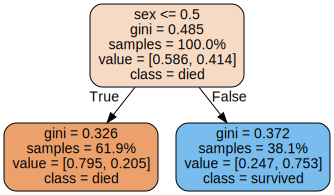

In [11]:
import graphviz

# Display decision tree
graphviz.Source(dot_data)

The graph encodes classes using colors. Nodes with a majority of samples labeled with "survived" appear in blue and nodes with a majority of samples labeled with "died" in orange. Each node contains the following information.

* gini - the impurity measure at this node
* samples - the percentage of samples in this node
* value - the probabilities for each class
* class - the class with the highest probability

The decision tree splits the data into two groups using a single rule on the sex of the passengers. **This feature is the most important one according to the Gini impurity measure.** Note that the node splits the samples by setting a threshold on the numerical label of the sex feature. Entries encoded with a zero (male) are in the left leaf and entries encoded with a one (female) are in the right leaf.

According to the samples entries in the image from above, there are respectively 61.9% and 38.1% of the samples in the left and right leaves. We can verify that using the value_counts() function from Pandas.

In [12]:
# Proportion of samples by sex
pd.value_counts(data_df.sex, normalize=True)

male      0.619048
female    0.380952
Name: sex, dtype: float64

The value entries in each leaf indicate the proportion of samples in each class. For instance, the left leaf has 79.5% of samples labeled with "died" and the remaining 20.5% labeled with "survived". Again, we can verify that using the crosstab() function from Pandas.

In [13]:
# Cross tabulation of sex and survived
crosstab = pd.crosstab(
    index=data_df.sex,
    columns=data_df.survived,
    normalize='index' # Normalize by sex
)
crosstab

survived,0,1
sex,,
female,0.246528,0.753472
male,0.794872,0.205128


The first row corresponds to the probabilities in the right leaf and the second row to the probabilities in the left one. Finally, let's use these probabilities to verify the Gini impurity values at each leaf

In [14]:
# Get p(survived) at each leaf
p_left = crosstab.loc['male', 1]
p_right = crosstab.loc['female', 1]

# Compute Gini impurity values
i_left = 2*p_left*(1-p_left)
i_right = 2*p_right*(1-p_right)
print('Gini impurity (left leaf): {:.3f}'.format(i_left))
# Prints: 0.326
print('Gini impurity (right leaf): {:.3f}'.format(i_right))
# Prints: 0.372

Gini impurity (left leaf): 0.326
Gini impurity (right leaf): 0.372


### Deeper trees
Let's try to increase the depth of the tree to two with the max_depth parameter.

In [15]:
# Create decision tree
dt_2 = DecisionTreeClassifier(
    criterion='gini', max_depth=2, random_state=0)

# Fit decision tree
dt_2.fit(X, y)

# Get score
dt_2.score(X, y)

0.8108465608465608

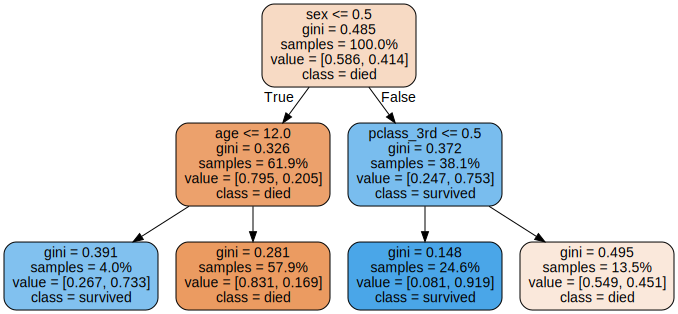

In [16]:
# Export decision tree
dot_data_2 = export_graphviz(
    dt_2, out_file=None,
    feature_names=features.columns, class_names=['died', 'survived'],
    filled=True, rounded=True, proportion=True   
)

# Display it
graphviz.Source(dot_data_2)

Again, one of the main advantages of the decision tree model is **its interpretability**. Here is a textual summary of the tree.

* Most men perished but young boys survived
* Most women survived, but half of the women from the 3rd class perished

However, the complexity of the tree increases with its depth, and it's easy to create a tree that overfits. For instance, let's remove the maximum depth criteria by setting it to None. This time, we will fit and evaluate the decision tree on different sets.

In [17]:
from sklearn.model_selection import train_test_split

# Split into train/test sets
X_tr, X_te, y_tr, y_te = train_test_split(
    X, y, test_size=0.3, random_state=0)

# Create decision tree
dt_max_depth = DecisionTreeClassifier(
    criterion='gini', max_depth=None, random_state=0)

# Fit decision tree
dt_max_depth.fit(X_tr, y_tr)

# Get train/test scores
print('Train accuracy: {:.3f}'.format(
    dt_max_depth.score(X_tr, y_tr)))
# Prints: 0.870

print('Test accuracy: {:.3f}'.format(
    dt_max_depth.score(X_te, y_te)))
# Prints: 0.784

Train accuracy: 0.870
Test accuracy: 0.784


As we can see, the decision tree correctly classifies 87% of the samples from the train set, but only 78.4% from the test set. **This is one of the main issues with decision trees. Small trees can be too simple (high bias) to model our data, and larger ones tend to overfit (high variance).**

### Summary

In this unit, we saw the basic idea behind decision trees and implemented one using Scikit-learn. Here are a few takeaways.

* Decision trees minimize an impurity measure at each split.
* The complexity of a decision tree depends on its depth.
* Scikit-learn DecisionTreeClassifier estimator requires categorical features to be encoded with one-hot encoding.

In practice, we use a decision tree when we want to build a **simple model that we can easily visualize and interpret**. However, we will see in the next unit that we can also combine **large trees into a random forest to create more complex models.**

### Question about multi class GINI
https://scikit-learn.org/stable/modules/tree.html


# Random Forests

In the last unit, we learned about decision trees and saw that **deep trees can lead to overfitting.** In this unit, we will see how to solve this issue by combining decision trees into a **random forest estimator**. We will start by discussing the intuition behind this model and then implement one using Scikit-learn.

### Intuition behind random forests

In the unit about the **bias-variance** trade-off, we saw two typical scenarios that can lead to poor results.

- Having a too simple model that is underfitting (high bias but low variance)
- Having a too complex model that is overfitting (low bias but high variance)

We usually solve the issue by tuning the complexity of the model using grid search. But in some cases, it's also possible to reduce individually the bias or the variance using ensemble methods such as **boosting or bagging**.

The idea behind **boosting is to chain simple estimators** (with a high bias) such that the strengths of each one compensate the weaknesses of the others. That way, we can reduce the overall bias. 
On the other hand, with **bagging, we try to reduce the variance of an estimator by averaging the predictions** from several instances of it trained on different samples of the data set. In this unit, we will learn about random forests which is an example of bagging.

Let's take an example. Say that we have a data set 
X
 with five data points x1, x2, x3, x4, x5. The idea behind bagging (**b**oostrap **agg**regating) is to generate different data sets by sampling points from X. These are **called bootstrap samples because we sample with replacement**. Hence, each new data set will likely contain duplicates. This image shows an example of bagging with three bootstrap samples X1, X2 and X3.

In [18]:
Image(url='https://d7whxh71cqykp.cloudfront.net/uploads/image/data/2804/bagging.svg', width = 800)


In this example, we generate the three bootstrap samples and then fit one estimator to each sample. To compute new predictions, we simply average the predictions from our ensemble of three estimators. **In random forests, these estimators are decision trees**. Each one is different since we use different versions of the data set to build them (the bootstrap samples). In addition to **bootstrapping, random forests decorrelate even more each tree by considering a random subset of the features** at each split. For instance, if our data contains ten features and we set the size of these random subsets to five, each split will try to find the binary statement that minimizes the split impurity among five randomly chosen features.

This may sound abstract, so let's go through a concrete example using Scikit-learn.

### Scikit-learn implementation

This time, we will work on a synthetic data set. Scikit-learn provides a make_circles() function to quickly test classification methods using a 2-dimensional toy data set with two classes. The function generates two nested circles. The outer one contains points from the negative class and the inner one points from the positive class. We can control the distance between each circle with the factor argument and the amount of noise with the noise one.

In [19]:
from sklearn.datasets import make_circles

# Generate circle data set
X, y = make_circles(
    n_samples=200, shuffle=True, noise=0.3, random_state=0, factor=0.3)

In this code, we generate a hundred samples from each circle and shuffle the points from the two classes. The function returns an input matrix X with two features and an output vector y with 0/1 values. Let's now plot the data

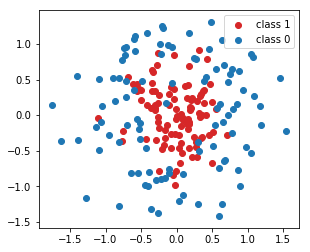

In [20]:
%matplotlib inline
import matplotlib.pyplot as plt

# Same scale for x- and y-axis
fig, ax = plt.subplots()
ax.set_aspect('equal', adjustable='box')

# Plot data
class1_idx = (y == 1)
ax.scatter(X[:, 0][class1_idx], X[:, 1][class1_idx], c='C3', label='class 1')
ax.scatter(X[:, 0][~class1_idx], X[:, 1][~class1_idx], c='C0', label='class 0')
ax.legend()
plt.show()

By default, Pyplot uses a slightly larger scale for the x-axis than for the y-axis. Hence, if we plot the data using the default settings, we would get two ellipses instead of two circles. We solve this using the set_aspect() function of the Pyplot Axes object.

Finally, we plot each class separately using the array of booleans class1_idx. You should get the following result.

In [21]:
from sklearn.ensemble import RandomForestClassifier

# Create a decision tree
dt = RandomForestClassifier(
    n_estimators=1, max_depth=5, random_state=0)

# Fit estimator
dt.fit(X, y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1, n_jobs=None,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In this example, our dt estimator corresponds to a decision tree with a depth of five. Let's visualize it by plotting its decision surface. We provide a decision_surface(ax, x1, x2, y, estimator) in the annex below to do that. The function is very similar to the ones that we used in the previous units. It generates a grid of values in the range of our two input variables x1 and x2, and classifies them using the predict() function from the estimator.

In [22]:
### Annex : Decision Surface function

import numpy as np

# Helper function
def decision_surface(ax, x1, x2, y, estimator):
    # Same scale for x- and y-axis
    ax.set_aspect('equal', adjustable='box')

    # Plot data points
    class1_idx = (y == 1)
    plt.scatter(x1[class1_idx], x2[class1_idx], color='C3', label='class 1')
    plt.scatter(x1[~class1_idx], x2[~class1_idx], color='C0', label='class 0')

    # Create a grid of values
    xlim, ylim = ax.get_xlim(), ax.get_ylim()
    x_values = np.linspace(*xlim, num=500)
    y_values = np.linspace(*ylim, num=500)
    xx, yy = np.meshgrid(x_values, y_values)
    grid_points = np.c_[xx.flatten(), yy.flatten()]

    # Compute predictions
    preds = estimator.predict(grid_points)
    zz = preds.reshape(xx.shape)

    # Draw decision boundary
    plt.contour(xx, yy, zz, levels=[0.5], colors='gray')

    # Plot decision surface with level curves
    plt.contourf(xx, yy, zz, alpha=0.1, cmap=plt.cm.coolwarm)
    plt.legend()
    plt.show()

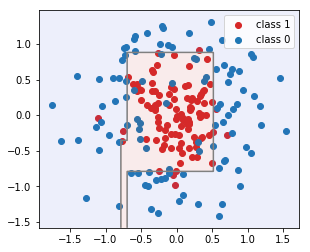

In [23]:
# Plot decision surface
fig, ax = plt.subplots()
decision_surface(ax, X[:, 0], X[:, 1], y, dt)

It seems that a single decision tree with a depth of five is too simple to model our two circles (high bias). Let's try to remove the limit on its depth by setting max_depth=None.

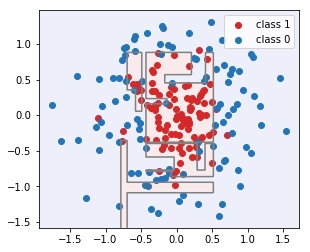

In [24]:
# Create a (deep) decision tree
dt_max_depth = RandomForestClassifier(
    n_estimators=1, max_depth=None, random_state=0)

# Fit estimator
dt_max_depth.fit(X, y)

# Plot decision surface
fig, ax = plt.subplots()
decision_surface(ax, X[:, 0], X[:, 1], y, dt_max_depth)

This time, the decision surface looks too complicated, and **our decision tree is overfitting (high variance)**. The idea behind random forests is to reduce the variance of our decision tree by combining several instances of it. Let's start with an ensemble of ten decision trees.

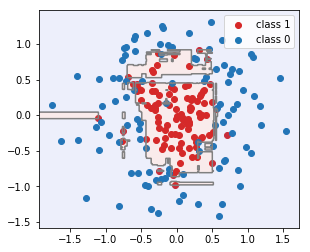

In [25]:
# Create random forest estimator
rf_10 = RandomForestClassifier(
    n_estimators=10, max_depth=None, random_state=0)

# Fit estimator
rf_10.fit(X, y)

# Plot decision surface
fig, ax = plt.subplots()
decision_surface(ax, X[:, 0], X[:, 1], y, rf_10)

It's important to understand that each decision tree in our ensemble is different. Remember that we fit each tree to a different bootstrap sample and that each split minimizes impurity among a random subset of the features. By default, the size of this random subset is equal to the square root of the total number of features. But it's possible to use other strategies with the max_features parameter. You can take a look at the documentation page if you want to learn more about it.

The results already look a bit better with ten decision trees. One of the advantages of decision trees is that they are fast to build and run. Hence, it's not rare in practice to combine several hundred of decision trees. Let's try with an ensemble of 200 estimators.


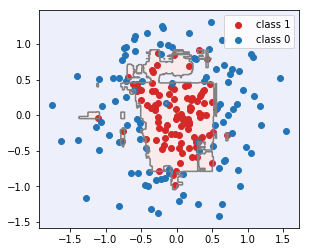

In [26]:
# Create a (large) random forest estimator
rf_200 = RandomForestClassifier(
    n_estimators=200, max_depth=None, random_state=0)

# Fit estimator
rf_200.fit(X, y)

# Plot decision surface
fig, ax = plt.subplots()
decision_surface(ax, X[:, 0], X[:, 1], y, rf_200)

We can now verify that the ensemble of trees achieves better results than the single tree using cross-validation. Let's evaluate each estimator using a (stratified) 10-fold cross-validation.

In [27]:
from sklearn.model_selection import cross_validate

# Mean test score of a single decision tree (max depth)
dt_scores = cross_validate(dt_max_depth, X, y, cv=10)
print('Decision tree - mean test {:.3f}'.format(
    np.mean(dt_scores['test_score'])))
# Prints: 0.780

# Mean test score of a random forest (200x, max depth)
rf_scores = cross_validate(rf_200, X, y, cv=10)
print('Random forest - mean test {:.3f}'.format(
    np.mean(rf_scores['test_score'])))
# Prints: 0.825

Decision tree - mean test 0.780
Random forest - mean test 0.825


The single tree has an average test accuracy of 78% whereas the ensemble achieves a mean accuracy of 82.5%.

### Note on multiclass vs. multilabel in Scikit-learn

We have already introduced **multiclass classification** problems in the logistic regression subject. Such problems are characterized by a label y, or a target value, that can take more than two possible options as opposed to binary classification. For example, classifying images of animals into three classes: "cat", "dog", and "horse". In this case, we have a single label per sample with three mutually exclusive classes (which means that a given sample can only belong to one of the three classes). The label 
y can be encoded using integers: "cat" takes the value 0, "dog" takes 1, and "horse" takes 
2. One can also perform one-hot encoding on y where "cat" takes [1,0,0], "dog" takes [0,1,0], and "horse" takes [0,0,1]. Mutual exclusivity means that an image can not be dog and horse at the same time, which means that the label [0,1,1] is not possible.

Let's now turn into **multilabel classifications** problems. In such problems, multiple classifications are done at the same time and each sample has more than one label. For example, assume the same set of images as before that we want to classify this time into the following: color of the animal "white" vs. "black", gender of the animal "male" vs. "female", and age of the animal "young" vs. "old". In this case, we have three labels for each sample since we are performing three different classifications. A given sample can be "white", "female", and "old" at the same time with y=["white","female","old"]. One can use binary encoding for each of the three classification problems: "white"/"black" map to 0/1,"male"/"female" map to 0/1, and "young"/"old" map to 0/1. In this case, the previous sample "white", "female", and "old" is mapped to y=[0,1,1].

You can now notice the difference between the last two examples: in multiclass classification we have a single classification problem with multiple classes (more than two), whereas in multilabel classification we have multiple classification problems. The confusion in some Scikit-learn models arises whenever we perform multiclass classification with one-hot encoded labels (for instance when the class "horse" is encoded as y=[0,0,1] in the example above). While this is a multiclass classification, the one-hot encoding can confuse some models and makes them perform multilabel classification by running three independent classifiers instead of a single multiclass classification. This approach is not completely wrong but might not lead to optimal performance.

This confusion might occur when using Scikit-learn models that support multilabel, such as DecisionTreeClassifier, RandomForestClassifier, and KNeighborsClassifier. In such cases and whenever a multiclass classification is performed, it is recommended to use integer encoding for labels y instead of one-hot encoding in order to avoid this confusion. Note that LogisticRegressiom only takes integer encoded labels, and no confusion between multiclass and multilabel is expected there.

To illustrate this, let's use the iris data set and create a KNeighborsClassifier for the three types of iris flowers.

In [28]:
from sklearn import datasets

# Load data set
iris = datasets.load_iris()

# Create X/y arrays
X = iris['data']
y = iris['target']

In [29]:
from sklearn.model_selection import train_test_split

# Split into train/test sets
X_tr, X_te, y_tr, y_te = train_test_split(
    X, y, test_size=0.3, random_state=0)

We will now create two types of encodings for the labels y, integer encoding and one-hot encoding

In [30]:
from sklearn.preprocessing import OneHotEncoder

# create one-hot encoder
encoder = OneHotEncoder(handle_unknown='ignore', sparse= False)

y_tr_hot = encoder.fit_transform(y_tr.reshape(-1,1))
y_te_hot = encoder.transform(y_te.reshape(-1,1))

# integer encoded labels
print(y_tr[0]) # Prints: 1

# one-hot encoded labels
print(y_tr_hot[0]) 

1
[0. 1. 0.]


Let's now train a KNeighborsClassifier using the integer encoded labels

In [31]:
from sklearn.neighbors import KNeighborsClassifier

# Create the estimator
knn = KNeighborsClassifier(n_neighbors=2)

# Fit it to train data
knn.fit(X_tr, y_tr)

# output the classes
print(knn.classes_) # Prints: [0 1 2]

# Accuracy on test set
accuracy = knn.score(X_te, y_te)
print('Accuracy: {:.3f}'.format(accuracy))

[0 1 2]
Accuracy: 0.978


We will now repeat the same thing but using the one-hot encoded labels and notice the difference in performance

In [32]:
# Create the estimator
knn = KNeighborsClassifier(n_neighbors=2)

# Fit it to train data (using one-hot encoded labels)
knn.fit(X_tr, y_tr_hot)

# output the classes
print(knn.classes_) # Prints: [array([0., 1.]), array([0., 1.]), array([0., 1.])]

# Accuracy on test set
accuracy = knn.score(X_te, y_te_hot)
print('Accuracy: {:.3f}'.format(accuracy))

[array([0., 1.]), array([0., 1.]), array([0., 1.])]
Accuracy: 0.956


You can notice the degradation in accuracy performance by 2%. This is because the Scikit-learn model got confused by the one-hot encoding of y and performed multilabel classification (three independent binary classifications in this example) instead of a single multiclass classification. You can notice this by printing the classes_ attribute as done above.

Note that this is a simple example for illustration purposes. In other scenarios, the difference in performance might be much bigger. **Therefore, it is essential to distinguish between these two types of classification available in the Scikit-learn library in order to decide which one to use based on the task at hand.** For further information on this topic, you can refer to this documentation page.

*Question :*

Multiclass vs. multilabel

Let's say we have a multilabel task with multiclass classification at the same time. For example, we need to classify each animal in terms of age, gender, and color (three features), but we have more than 2 colors as opposed as in your example.
Would the recommended method be to use binary encoding for age and gender, and then integers for color? Or could we also use binary encoding for age and gender, and then one-hot encoding for color? And which would be best?
In summary, isn't it always better to use binary encoding and/or integers rather than one-hot encoding (especially since we know one-hot encoding can also create collinearity issues if first column is not removed)? Or is there a case when one-hot encoding is better or more useful? Many thanks

*Answer :*

Good question. This situation is called "multiclass-multioutput" classification, also known as "multitask" classification, in sklearn jargon (check here https://scikit-learn.org/stable/modules/multiclass.html#multiclass-multioutput-classification). Encoding the labels depends on the convention of each library. In sklearn convention, the mutually exclusive classes should not be encoded via one-hot encoding in general (mutually exclusive means that the color can not be green and red at the same time). In other libraries, such as Keras as you will see later, you can employ both types of encoding and adapt the cost function accordingly.

The discussion of colinearity has to do with the encoding of the input features, not the output labels. The reason one-hot encoding is not recommended for label encoding in sklearn is related to the underlying convention of sklearn's cost functions that does not assume mutual exclusivity in some cases.


### Summary
In this unit, we learned about bagging and random forests and saw that we can reduce the variance (and hence increase performance) of an estimator by combining several instances of it.

In the next unit, we will learn about **support vector machines (SVMs)** and see how to implement them using Scikit-learn.

# Support Vector Machines (SVM)

In this unit, we will learn about support vector machines (SVMs). We will start by discussing the intuition behind this model and learn about the kernel trick. We will then test it on the circles data set from the previous unit using Scikit-learn estimators.

In the last units, we plotted the decision boundary of different estimators. Intuitively, we want these boundaries to be far from the data points of the different classes in our problem. For instance, here is a sample data set with three possible decision boundaries.



In [49]:
Image(url='https://d7whxh71cqykp.cloudfront.net/uploads/image/data/2798/svm-max-margin.svg', width = 500)

The blue and the red ones both classify the data points from the two classes without making any mistakes. However, we expect the estimator that corresponds to the red boundary to give better results than the blue one because the red line is farther away from the data points from both classes. Hence, it should generalize better.

This is the idea behind support vector machines. **SVMs try to find the separation with the maximum margin around it**. To achieve this, the model minimizes the hinge loss.

> $hinge(s)=max(0,1−ys)$

In this formula, $s$ is the output of the SVM classifier and $y$ the class label. The output $s$ determines on which side of the decision boundary a data point is. The model predicts the positive class if the output is positive, and the negative class if the output is negative. The class labels $y$ are either -1 for the negative class or +1 for the positive class (instead of the usual 0/1 values). Here is a plot of the hinge formula in the two cases.

In [50]:
Image(url='https://d7whxh71cqykp.cloudfront.net/uploads/image/data/5622/hinge-loss.svg', width = 500)

It is important to understand that the hinge loss can penalize points even if they are on the correct side of the decision boundary. For instance, for the positive class (blue line), output values between 0 and 1 have a nonzero loss value even if they are correctly classified (the output is positive). Similarly, for the negative class (red line), the hinge loss penalizes points with an output value between -1 and 0. **his "penalization" area around the decision boundary is called the margin of the SVM classifier.**

Here is an image of a possible decision boundary and its margin. Minus and plus signs denote points from the negative and the positive classes. We mark data points that are either inside the margin or on the wrong side of the decision boundary (misclassified) in red.

In [51]:
Image(url='https://d7whxh71cqykp.cloudfront.net/uploads/image/data/2796/svm-margin.svg', width = 500)

These data points in red are the only ones with a **nonzero loss value**. In that sense, the decision boundary only depends on this (typically small) subset of data points called **support vectors**.

To summarize, support vector machines try to find a decision boundary with the largest margin while minimizing the number of data points inside its margin or on the wrong side of the decision boundary. In practice, we can control this trade-off with a C parameter. Small values produce classifiers that try to maximize the margin (can lead to underfitting) whereas larger values produce classifiers that try to avoid misclassifying data points (can lead to overfitting). In that sense, this C parameter controls the **complexity of the model** and is similar to the C parameter in logistic regressions.

# Nonlinear classification

We saw above that SVMs try to find the output values s that minimize the hinge loss. These output values correspond to the usual linear model in which we multiply feature values with coefficients from a vector w (just like linear regressions).

This model can be too rigid in some cases when there are nonlinear relationships between the variables. But we can solve this issue by introducing new features. For instance, here is a modified version of the circles data set from the previous unit. This time, the two classes don't overlap. This data set is not linearly separable in the sense that we cannot draw a line that separates the two classes.

In [53]:
Image(url='https://d7whxh71cqykp.cloudfront.net/uploads/image/data/5623/nonlin-2d.svg', width = 300)

But we can add new variables to make it linearly separable. For instance, one solution is to add x3=x1^2+x2^2. Here is a plot of the data in this "extended" feature space with three variables.

In [56]:
Image(url='https://d7whxh71cqykp.cloudfront.net/uploads/image/data/5624/nonlin-3d.svg', width = 400)

As we can see, it's now possible to draw a hyperplane to separate the data points from the two classes (e.g., x3=0.3).

In this case, we were able to perform nonlinear classification by adding a new feature. **However, with support vector machines, there is an easier way to achieve this called the kernel trick.**

### Dual problem and kernel trick

Before learning about the kernel trick, we need to discuss the idea of **duality** in optimization. We won't go into the details, but in short, every optimization problem can be seen from two perspectives which are equivalent. In our case, it's possible to reformulate our problem of finding a vector of coefficients w into its dual problem in which we want to find a vector α where each entry corresponds to a data point in our training set. You can think of this vector as a way to indicate how important each point is to determine on which side of the decision boundary we are.

The main advantage of working with the dual is that the solution doesn't depend on the input matrix X directly but on the product XX⊺ which is called the **kernel matrix.**

> $K=XX⊺$

K is an (n,n) matrix where n is the number of data points. Since the i-th row of X corresponds to the i-th data point, the j-th column of X⊺ corresponds to the j-th data point, and the (i,j) element of K is the product between them. Hence, another way to write this matrix is to use a function k that takes two data points and computes their product.

> $k(xi,xj)=x⊺ixj$

This **function k is called the linear kernel** and is equivalent to the kernel matrix 
K from above. The idea behind the **kernel trick** is to compute this product in **another feature space** where our data becomes linearly separable.

> $k(xi,⃗xj)=ϕ(⃗xi)⊺ϕ(⃗xj)$

In this notation, the letter ϕ (phi) denotes the new feature space and ϕ(⃗xi) corresponds to the value of the vector ⃗xi in this new feature space. In the circles example from above, the new feature space corresponds to the 3-dimensional space with the additional feature.

Note that it's not necessary to know what this new feature space is as long as we can compute the product between the two vectors in it. In particular, it can have an infinite number of dimensions. One example of this is the **popular RBF kernel.**

> $k(⃗xi,⃗xj)=e^(−γ∥⃗xi−⃗xj∥)^2$

As you can see, the kernel function k is not defined as a product between the two data points. Instead, the value of the kernel is a function of the Euclidean distance between the two points ∥⃗xi−⃗xj∥. You can think of it as a similarity measure.

In [58]:
Image(url='https://d7whxh71cqykp.cloudfront.net/uploads/image/data/5625/rbf-kernel.svg', width = 500)

Points that are close to each other have a kernel value close to one and points that are far from each other have a value close to zero. The γ (gamma) parameter controls how much the points can affect each other. Large gamma values produce small kernel values, except if the two points are close to each other, and we can increase the effect of points further away by decreasing gamma.

Support vector machines are very popular due to this kernel trick. Note that this technique is not specific to SVMs. For instance, it's possible to reformulate ridge regression to obtain **kernel ridge regression (KRR)**. In practice, working with kernels can be computationally expensive because we need to evaluate the kernel function for any pair of data points. However, support vector machines work well with kernels because the decision boundary only depends on a subset of the data points with a nonzero entry in the α parameter (the support vectors).

### Scikit-learn implementation

We now know the intuition behind support vector machines and kernels. Let's see how to use them with Scikit-learn. We will use the circles data set from the previous unit.

In [39]:
from sklearn.datasets import make_circles

# Generate circle data set
X, y = make_circles(
    n_samples=200, shuffle=True, noise=0.3, random_state=0, factor=0.3)

Let's start with linear SVM. Scikit-learn provides a LinearSVC estimator which is a very efficient implementation of support vector machines with a linear kernel.

In [40]:
from sklearn.svm import LinearSVC

# Create SVM with linear kernel
linear_svc = LinearSVC()

# Fit estimator
linear_svc.fit(X, y)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

In this code, we create the estimator and fit it to the data. Let's use the decision_surface() function from the previous unit to visualize its decision boundary.

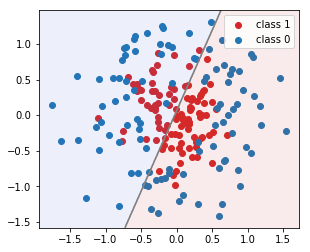

In [41]:
# Plot decision surface
fig, ax = plt.subplots()
decision_surface(ax, X[:, 0], X[:, 1], y, linear_svc)

**As we saw above, the linear kernel can only perform linear classification**.
Hence, the only way to classify these data points correctly using this linear_svc classifier is to **add new features to the data set**. 
However, we know from above that **we can also perform nonlinear classification using other kernels**. Scikit-learn provides an SVC estimator that implements many different ones.

In [42]:
from sklearn.svm import SVC

# Create SVM with RBF kernel
rbf_svc_c1 = SVC(kernel='rbf', C=1)

# Fit estimator
rbf_svc_c1.fit(X, y)

C:\Users\lyeso\anaconda3\envs\exts-ml\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In this code, we create an SVM classifier with an RBF kernel and set the C value to one. Let's visualize its decision boundary.

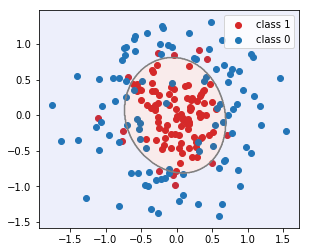

In [43]:
# Plot decision surface
fig, ax = plt.subplots()
decision_surface(ax, X[:, 0], X[:, 1], y, rbf_svc_c1)

This time, the boundary forms an ellipse around the data points from the positive class. In our case, we know that the data was generated using a circle. Hence, this elliptical decision boundary might be a sign of overfitting. We saw above that **we can reduce overfitting by decreasing the value of C**. Let's try with a value of 0.1.

C:\Users\lyeso\anaconda3\envs\exts-ml\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


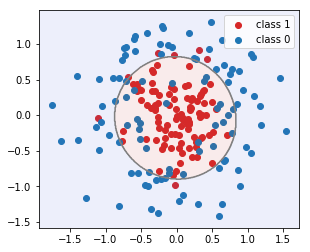

In [44]:
# Create SVM estimator with RBF kernel and C=0.1
rbf_svc_c01 = SVC(kernel='rbf', C=0.1)

# Fit estimator
rbf_svc_c01.fit(X, y)

# Plot decision surface
fig, ax = plt.subplots()
decision_surface(ax, X[:, 0], X[:, 1], y, rbf_svc_c01)

This time, we get a nice circle that should generalize better to new data points.

Gamma γ is another important parameter of the RBF kernel which controls how much influence each data point has. You can think of this **gamma parameter as a way to control how smooth the decision boundary is**. Let's try to increase the default value of one to a hundred.

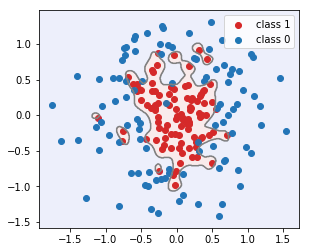

In [45]:
# Create RBF SVM with C=1 and gamma=100
rbf_svc_g100 = SVC(kernel='rbf', C=1, gamma=100)

# Fit estimator
rbf_svc_g100.fit(X, y)

# Plot decision surface
fig, ax = plt.subplots()
decision_surface(ax, X[:, 0], X[:, 1], y, rbf_svc_g100)

As we can see, the decision surface becomes very complex and **starts overfitting**. If we keep increasing gamma, data points need to be really to close to each other to be affected and the classifier cannot generalize anymore.

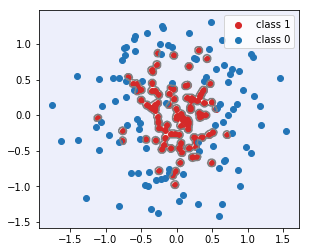

In [46]:
# Create RBF SVM with C=1 and large gamma value
rbf_svc_g1000 = SVC(kernel='rbf', C=1, gamma=1000)

# Fit estimator
rbf_svc_g1000.fit(X, y)

# Plot decision surface
fig, ax = plt.subplots()
decision_surface(ax, X[:, 0], X[:, 1], y, rbf_svc_g1000)

On the other hand, we can reduce the complexity of the model by decreasing gamma. Let's try to set it to 0.1.

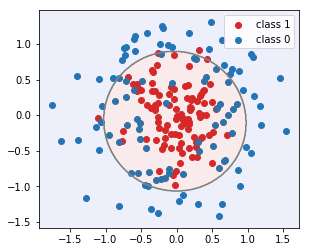

In [47]:
# Create RBF SVM with C=1 and gamma=0.1
rbf_svc_g01 = SVC(kernel='rbf', C=1, gamma=0.1)

# Fit estimator
rbf_svc_g01.fit(X, y)

# Plot decision surface
fig, ax = plt.subplots()
decision_surface(ax, X[:, 0], X[:, 1], y, rbf_svc_g01)

The decision boundary is very similar to the rbf_svc_c01 estimator one from above.

Finally, let's try with a small gamma value.

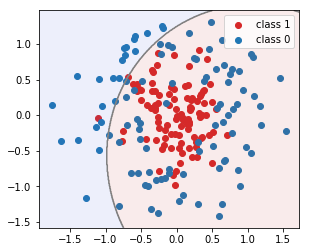

In [48]:
# Create RBF SVM with C=1 and small gamma value
rbf_svc_g001 = SVC(kernel='rbf', C=1, gamma=0.01)

# Fit estimator
rbf_svc_g001.fit(X, y)

# Plot decision surface
fig, ax = plt.subplots()
decision_surface(ax, X[:, 0], X[:, 1], y, rbf_svc_g001)

This time, the decision boundary is "too smooth" to model the data, and our **estimator is underfitting**. In practice, it's critical to have good C and γ values, and we usually **tune them using grid search.**

### Liblinear versus libsvm

If you take a look at the documentation page of the SVC estimator, you can see that it's also possible to use the linear kernel by setting the kernel parameter to linear. Hence, there are two ways to fit a support vector machine with a linear kernel.

> - With the LinearSVC estimator
> - By setting kernel='linear' in an SVC estimator

In fact, these two estimators compute the optimal vector ⃗α in two different ways. The LinearSVC estimator uses the **"liblinear" solver (based on the coordinate descent algorithm) which should scale better to a large number of samples.** On the other hand, the SVC estimator uses the **"libsvm" solver (based on the SMO algorithm) which can work with nonlinear kernels but is slower than liblinear.**

Hence, we usually create a LinearSVC estimator when the kernel is linear and use the SVC one when we want to test other kernels. However, note that **SVC doesn't scale well to a large number of data points** which can be an important limitation in practice.

### Summary

In this unit, we learned about support vector machines and the kernel trick. In the next exercise, you will be able to experiment with SVMs and the RBF kernel on a data set designed for nonlinear classification. This a good opportunity to experiment with different C and γ values and see their effect on the decision boundary.